In [ ]:
#Importing the liberaries

import pandas as pd
import numpy as np
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt  #for ploting the figures
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf #For ploting ACF and PACF
from statsmodels.tsa.arima_model import ARMA # For running ARMA model
register_matplotlib_converters()
from time import time

# Catfish Sales Data

In [ ]:
def parser(s):
    return datetime.strptime(s, '%Y-%m-%d')  #Year - month -date

now we will use CSV file to retrive data from there

In [ ]:
#read data
fish_sales = pd.read_csv('https://raw.githubusercontent.com/nihalk17/Public_One/main/catfish4.csv', parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)

In [ ]:
fish_sales.head() #For look at Starting datas

Date
1986-01-01     9034
1986-02-01     9596
1986-03-01    10558
1986-04-01     9002
1986-05-01     9239
Name: Total, dtype: int64

In [ ]:
num_lags = 30

In [ ]:
#infer the frequency of the data
fish_sales = fish_sales.asfreq(pd.infer_freq(fish_sales.index))

In [ ]:
start = datetime(2000,1,1)
end= datetime(2004,1,1)
set_fish_sales = fish_sales[start:end]

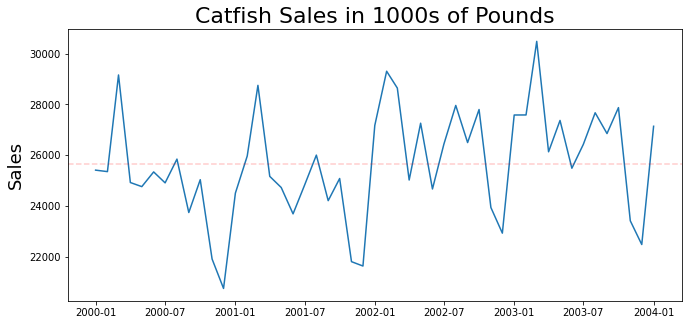

In [ ]:
plt.figure(figsize=(11,5))
plt.title('Catfish Sales in 1000s of Pounds', fontsize=22)
plt.ylabel('Sales', fontsize=18)
plt.plot(set_fish_sales)
plt.axhline(set_fish_sales.mean(), color='r', alpha=0.2, linestyle='--')

Here we can see data is not staionary hence we will take first difference and make it stationary

In [ ]:
first_diff = set_fish_sales.diff()[1:]

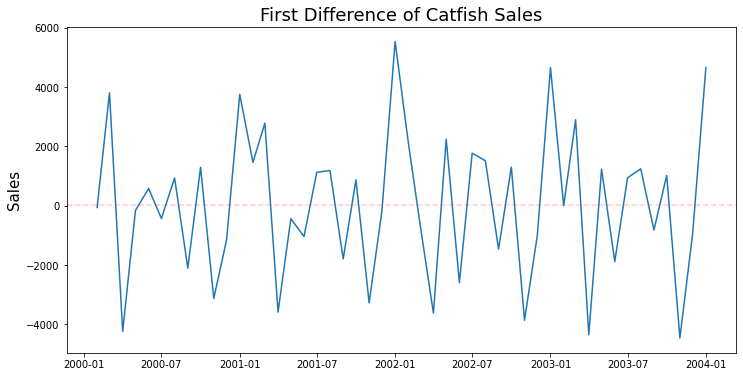

In [ ]:
plt.figure(figsize=(12,6))
plt.title('First Difference of Catfish Sales', fontsize=18)
plt.ylabel('Sales', fontsize=15)
plt.plot(first_diff)
plt.axhline(first_diff.mean(), color='r', alpha=0.2, linestyle='--')#For ploting horizontalat 0 sales

Now data become stationary

ACF

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:662: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:671: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning,


<BarContainer object of 30 artists>

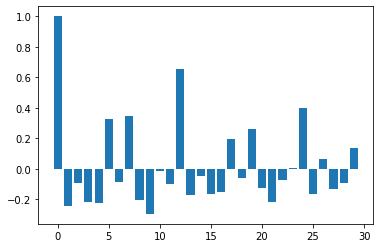

In [ ]:
ACF = acf(first_diff)
plt.bar(range(num_lags), ACF[:num_lags]) #It plots Auto correlation finction with specified lags

Here we can see first lag error terms is significant Based on ACF, we should start with a MA(1) process

PACF

In [ ]:
PACF = pacf(first_diff)
plt.bar(range(num_lags), PACF[:num_lags])

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1029: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs // 2 - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  FutureWarning,


ValueError: ignored

Here if we look at some starting lags , lag 4 is significant,Based on PACF, we should start with a AR(4) process

Get training and testing sets

In [ ]:
train_end = datetime(2003,7,1)
test_end = datetime(2004,1,1)

trained_data = first_diff[:train_end]
test_data = first_diff[train_end + timedelta(days=1):test_end]

Fit the ARMA Model

In [ ]:
# define model
fish_model = ARMA(trained_data, order=(4,1))

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


In [ ]:
#fit the model
start = time()
model_fit = fish_model.fit()
end = time()
print('Model Fitting Time:', end - start)

Model Fitting Time: 0.20544171333312988


It is small when we take starting initial lag term in pacf but it will be much heigher when we take higher lag error term there model does not work goof hence then we use other models

In [ ]:
#It will print summary of model and some important terms
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                  Total   No. Observations:                   42
Model:                     ARMA(4, 1)   Log Likelihood                -376.584
Method:                       css-mle   S.D. of innovations           1850.781
Date:                Wed, 19 Oct 2022   AIC                            767.167
Time:                        18:49:29   BIC                            779.331
Sample:                    02-01-2000   HQIC                           771.626
                         - 07-01-2003                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          37.2620    129.751      0.287      0.774    -217.045     291.569
ar.L1.Total    -0.8666      0.185     -4.692      0.000      -1.229      -0.505
ar.L2.Total    -0.4236      0.166     -2.547    

In [ ]:
#Now we will get prediction of start and end dates
predicted_startdate = test_data.index[0]
predicted_enddate = test_data.index[-1]

In [ ]:
#get the predictions and residuals
predictions = model_fit.predict(start=predicted_startdate, end=predicted_enddate)
residuals = test_data - predictions

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


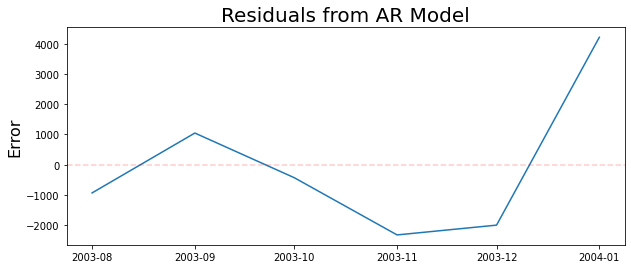

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(residuals) #ploting residuals
plt.title('Residuals from AR Model', fontsize=20)
plt.ylabel('Error', fontsize=16)
plt.axhline(0, color='r', linestyle='--', alpha=0.2)

Text(0, 0.5, 'Sales')

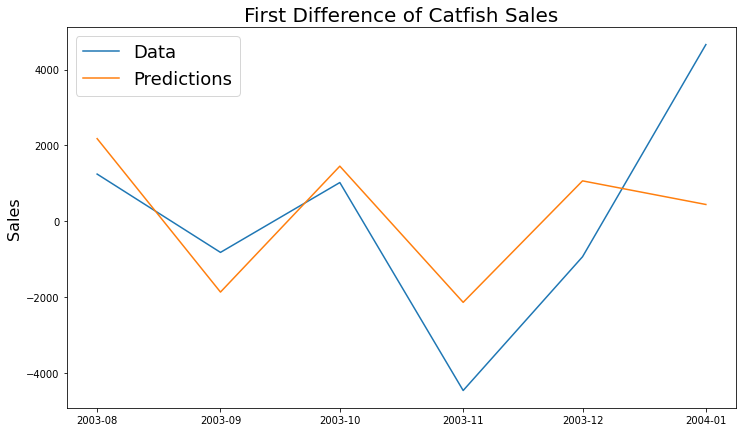

In [ ]:
plt.figure(figsize=(12,7))
plt.plot(test_data)
plt.plot(predictions)#This plots predicted data of sales of fish
plt.legend(('Data', 'Predictions'), fontsize=18)
plt.title('First Difference of Catfish Sales', fontsize=20)
plt.ylabel('Sales', fontsize=16)